# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Wind Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\wind_production_dataset.csv')

data.head()

,Country,Date,Value,Wind10int,Wind100int
0,Australia,2023-03-01,2415.8842,3.689722,5.550105
1,Australia,2023-02-01,2540.7584,3.966472,5.909515
2,Australia,2023-01-01,2614.8241,4.017246,5.866050
3,Australia,2022-12-01,2690.1965,4.128255,6.038626
4,Australia,2022-11-01,2510.9518,4.213749,6.209358


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

wind_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'wind' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Wind10int', 'Wind100int']
    ]
    
    # Store the filtered data in the dictionary
    wind_production_data[country] = country_energy_production.reset_index(drop=True)

wind_production_data['Brazil']

,Date,Value,Wind10int,Wind100int
0,2023-03-01,6243.3895,1.868388,3.181936
1,2023-02-01,6631.1419,1.862335,3.145249
2,2023-01-01,6393.0241,1.885541,3.181045
3,2022-12-01,6318.9355,2.016006,3.395450
4,2022-11-01,6010.5997,2.146455,3.590040
...,...,...,...,...
94,2015-05-01,1572.2170,2.018152,3.460157
95,2015-04-01,993.7980,1.729579,2.940870
96,2015-03-01,1115.3550,1.736034,2.926099
97,2015-02-01,1162.7520,1.972477,3.301410


# Resample to daily data

In [4]:
for country_data in wind_production_data:
    
    # set time as the index
    wind_production_data[country_data]['Date'] = pd.to_datetime(wind_production_data[country_data]['Date'])
    wind_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    wind_production_data[country_data]['Value'] = (wind_production_data[country_data]['Value']/
                                                    wind_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = wind_production_data[country_data].resample('D').interpolate('linear')
    wind_production_data[country_data] = daily_data
    
wind_production_data['Brazil']

,Value,Wind10int,Wind100int
Date,,,
2015-01-01,49.778065,1.945945,3.208612
2015-01-02,49.511897,1.946801,3.211605
2015-01-03,49.245729,1.947657,3.214599
2015-01-04,48.979561,1.948513,3.217592
2015-01-05,48.713393,1.949369,3.220586
...,...,...,...
2023-02-25,206.460638,1.867523,3.176695
2023-02-26,205.195394,1.867739,3.178005
2023-02-27,203.930150,1.867955,3.179315


# Model Building

### Split train and test data

In [88]:
data = wind_production_data['Brazil']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value  Wind10int  Wind100int
Date                                        
2015-01-01  49.778065   1.945945    3.208612
2015-01-02  49.511897   1.946801    3.211605
2015-01-03  49.245729   1.947657    3.214599
2015-01-04  48.979561   1.948513    3.217592
2015-01-05  48.713393   1.949369    3.220586
(2193, 3)

                 Value  Wind10int  Wind100int
Date                                         
2021-01-01  181.183206   1.960470    3.275776
2021-01-02  179.534136   1.957504    3.272087
2021-01-03  177.885065   1.954538    3.268398
2021-01-04  176.235995   1.951572    3.264709
2021-01-05  174.586924   1.948605    3.261020
(790, 3)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,0)(0,1,0)[365] 

#### Figure below show the result from R:
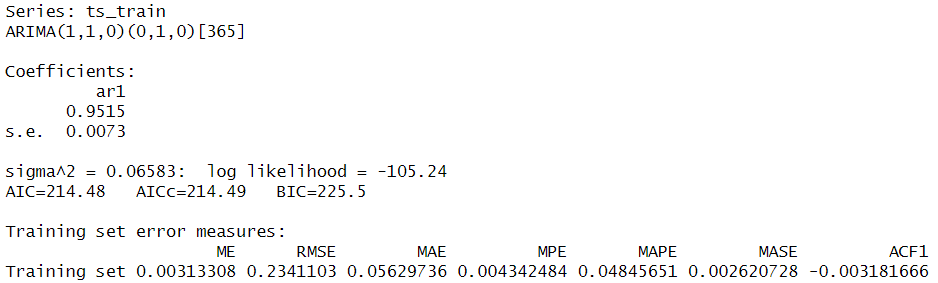

In [86]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
brz_wind_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\brz_wind_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [89]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(brz_wind_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  156.67756690324228
Mean Squared Error:  28600.816584055414
Root Mean Squared Error:  169.11775951701648


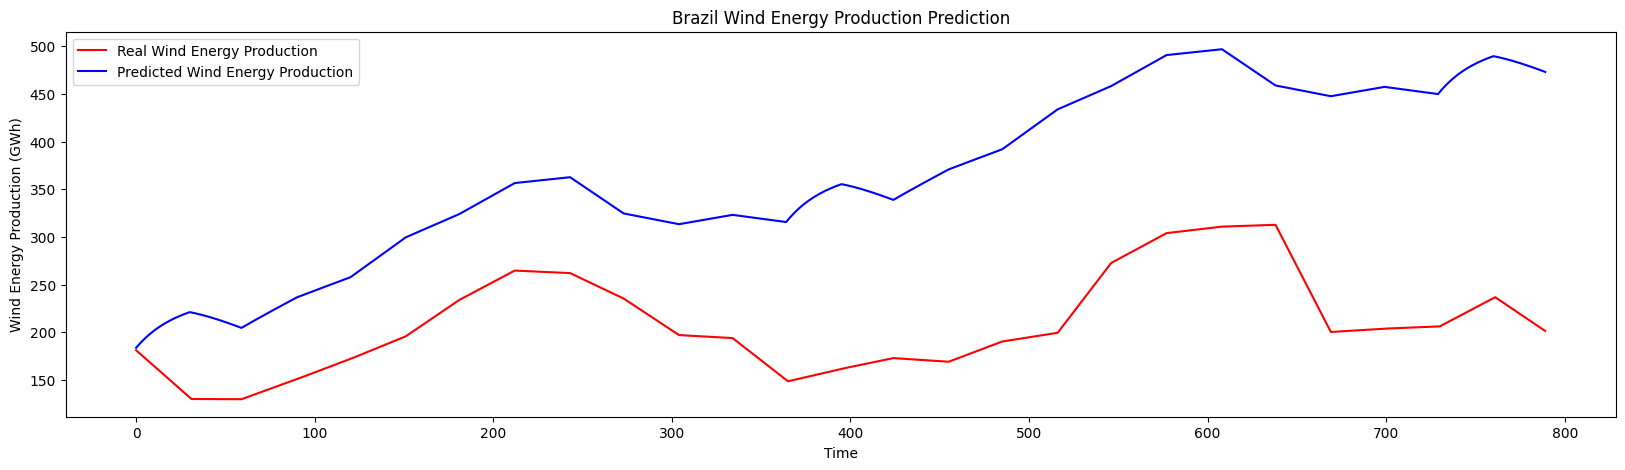

In [90]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Brazil Wind Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## XGBoost - Univariate

In [91]:
def create_features(df, label=None):

    #Creates time series features from datetime index
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int64')
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [92]:
X_train, y_train = create_features(train.copy(), label='Value')
X_test, y_test = create_features(test.copy(), label='Value')

print(X_train.head())
print(X_train.shape)
print()
print(y_train.head())
print(y_train.shape)
print()
print(X_test.head())
print(X_test.shape)
print()
print(y_test.head())
print(y_test.shape)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2015-01-01          3        1      1  2015          1           1           1
2015-01-02          4        1      1  2015          2           2           1
2015-01-03          5        1      1  2015          3           3           1
2015-01-04          6        1      1  2015          4           4           1
2015-01-05          0        1      1  2015          5           5           2
(2193, 7)

Date
2015-01-01    49.778065
2015-01-02    49.511897
2015-01-03    49.245729
2015-01-04    48.979561
2015-01-05    48.713393
Freq: D, Name: Value, dtype: float64
(2193,)

            dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear
Date                                                                          
2021-01-01          4        1      1  2021          1           1          53
2021-01-02          5       

In [12]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [13]:
brz_daily_xgb = xgb.XGBRegressor(n_estimators=1000)
brz_daily_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:89.82576	validation_1-rmse:170.09284
[1]	validation_0-rmse:63.37084	validation_1-rmse:138.43016
[2]	validation_0-rmse:44.77287	validation_1-rmse:116.60921
[3]	validation_0-rmse:31.67863	validation_1-rmse:101.12978
[4]	validation_0-rmse:22.48010	validation_1-rmse:90.78134
[5]	validation_0-rmse:16.03978	validation_1-rmse:83.17857
[6]	validation_0-rmse:11.53165	validation_1-rmse:78.07732
[7]	validation_0-rmse:8.37170	validation_1-rmse:74.59320
[8]	validation_0-rmse:6.16944	validation_1-rmse:72.19250
[9]	validation_0-rmse:4.69106	validation_1-rmse:70.52360
[10]	validation_0-rmse:3.63438	validation_1-rmse:69.37705
[11]	validation_0-rmse:2.88830	validation_1-rmse:68.53063
[12]	validation_0-rmse:2.45959	validation_1-rmse:67.96097
[13]	validation_0-rmse:2.14330	validation_1-rmse:67.54643
[14]	validation_0-rmse:1.98188	validation_1-rmse:67.25292
[15]	validation_0-rmse:1.82659	validation_1-rmse:67.09016
[16]	validation_0-rmse:1.69465	validation_1-rmse:66.98196
[17]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

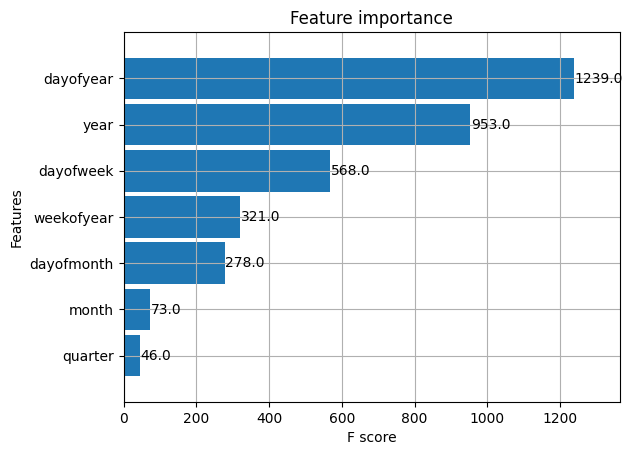

In [14]:
_ = plot_importance(brz_daily_xgb, height=0.9)

In [93]:
xgb_y_pred = brz_daily_xgb.predict(X_test)

In [94]:
print("Mean Absolute Error: ", mean_absolute_error(xgb_y_pred, test['Value'].values))
mse = mean_squared_error(xgb_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  58.34258725244028
Mean Squared Error:  4436.0074658755275
Root Mean Squared Error:  66.6033592687


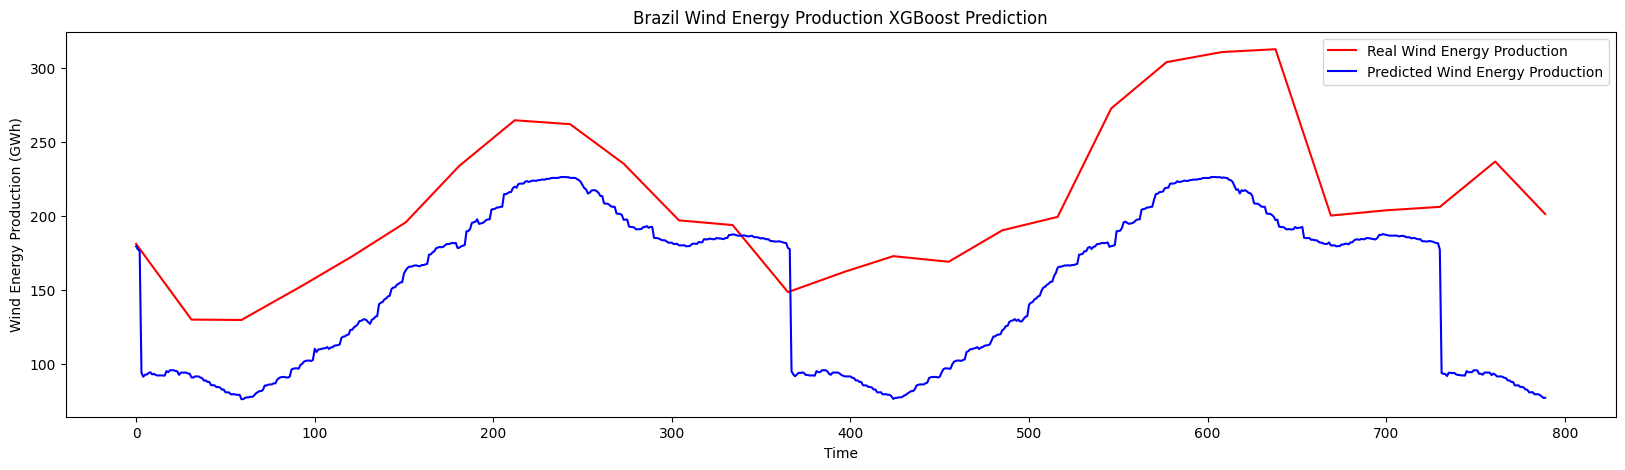

In [95]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(xgb_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Brazil Wind Energy Production XGBoost Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [18]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [96]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previoBrazil time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [97]:
# Build and Train the SVM Model
brz_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01) # Specify hyperparameters
brz_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [98]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Wind Energy Production
svr_y_pred = brz_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [99]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.9652437521504966
Mean Squared Error:  5.365915513008942
Root Mean Squared Error:  2.3164445844891137


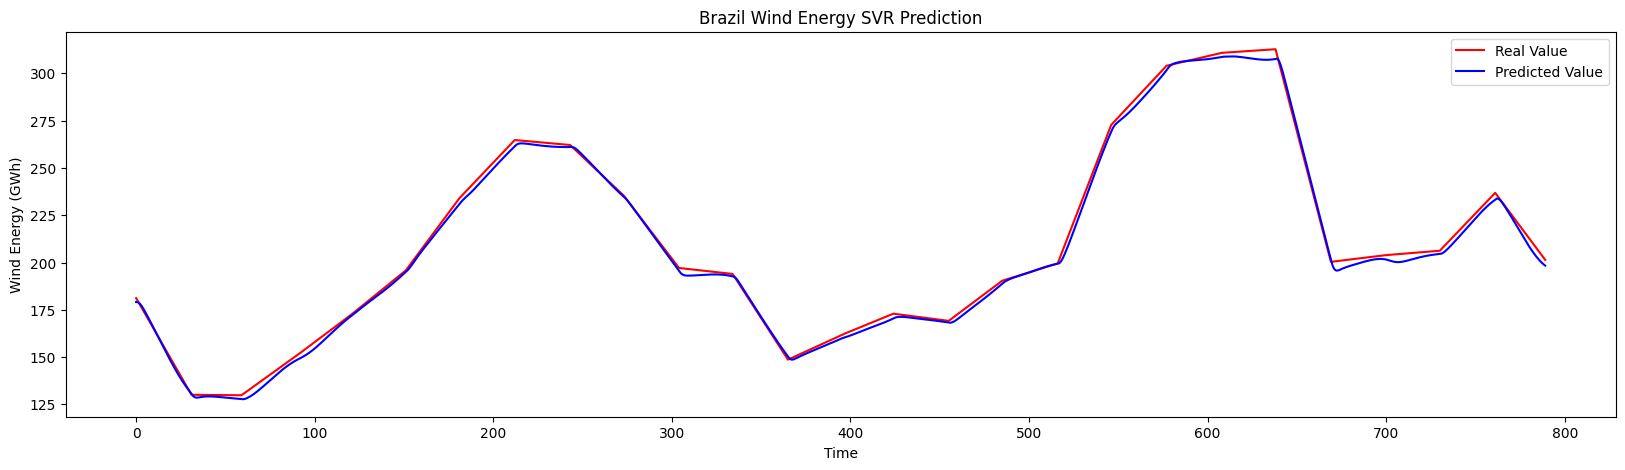

In [100]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Wind Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [111]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [112]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [113]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
brz_daily_gru = Sequential()
brz_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
brz_daily_gru.add(GRU(units=64, input_shape=(time_steps, 1)))
brz_daily_gru.add(Dense(1, activation='linear'))

brz_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [114]:
brz_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 74s 355ms/step - loss: 0.0164
Epoch 2/100
58/58 [==============================] - 19s 334ms/step - loss: 1.9997e-04
Epoch 3/100
58/58 [==============================] - 19s 334ms/step - loss: 1.3474e-04
Epoch 4/100
58/58 [==============================] - 19s 334ms/step - loss: 1.1365e-04
Epoch 5/100
58/58 [==============================] - 18s 312ms/step - loss: 9.8493e-05
Epoch 6/100
58/58 [==============================] - 18s 316ms/step - loss: 8.5580e-05
Epoch 7/100
58/58 [==============================] - 20s 343ms/step - loss: 7.6789e-05
Epoch 8/100
58/58 [==============================] - 17s 297ms/step - loss: 7.0857e-05
Epoch 9/100
58/58 [==============================] - 20s 341ms/step - loss: 6.2536e-05
Epoch 10/100
58/58 [==============================] - 18s 307ms/step - loss: 5.7124e-05
Epoch 11/100
58/58 [==============================] - 16s 284ms/step - loss: 5.2872e-05
Epoch 12/100
58/58 [=========================

58/58 [==============================] - 15s 259ms/step - loss: 1.8703e-05
Epoch 95/100
58/58 [==============================] - 15s 265ms/step - loss: 6.9734e-06
Epoch 96/100
58/58 [==============================] - 16s 282ms/step - loss: 3.9964e-06
Epoch 97/100
58/58 [==============================] - 16s 267ms/step - loss: 5.9775e-06
Epoch 98/100
58/58 [==============================] - 16s 281ms/step - loss: 9.7739e-06
Epoch 99/100
58/58 [==============================] - 14s 241ms/step - loss: 5.1431e-06
Epoch 100/100
58/58 [==============================] - 14s 239ms/step - loss: 6.6565e-06


In [115]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = brz_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 17s 66ms/step


In [116]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.1729619018796489
Mean Squared Error:  1.6781036331691666
Root Mean Squared Error:  1.2954163937395444


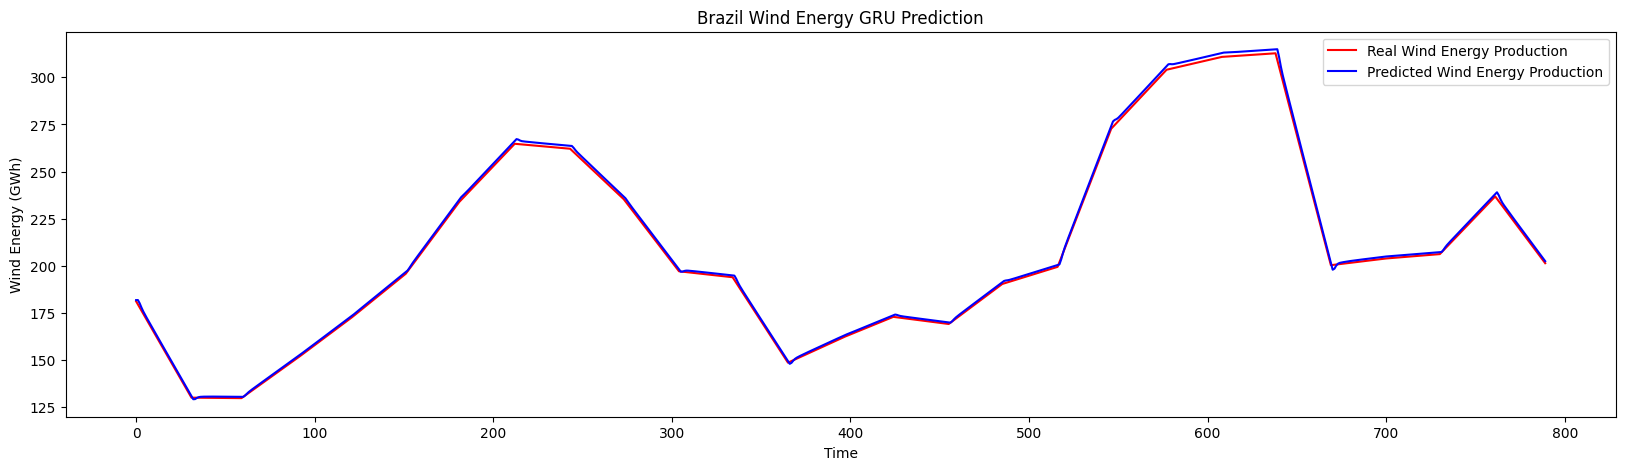

In [117]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Brazil Wind Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [118]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.08524939]
 [0.08388671]
 [0.08252403]
 ...
 [0.76055992]
 [0.75927773]
 [0.75799554]]
(2193, 1)


In [119]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [120]:
print(X_train)
X_train.shape

[[0.08524939 0.08388671 0.08252403 ... 0.06713734 0.06287784 0.05861834]
 [0.08388671 0.08252403 0.08116135 ... 0.06287784 0.05861834 0.05435885]
 [0.08252403 0.08116135 0.07979866 ... 0.05861834 0.05435885 0.05747389]
 ...
 [0.3048616  0.29233747 0.29330929 ... 0.76440649 0.7631243  0.76184211]
 [0.29233747 0.29330929 0.29428111 ... 0.7631243  0.76184211 0.76055992]
 [0.29330929 0.29428111 0.29525293 ... 0.76184211 0.76055992 0.75927773]]


(1828, 365)

In [121]:
print(y_train)
y_train.shape

[0.05435885 0.05747389 0.06058894 ... 0.76055992 0.75927773 0.75799554]


(1828,)

In [122]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [66]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [67]:
# Initialising the RNN
brz_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
brz_daily_uni_lstm.add(Dropout(0.2))

brz_daily_uni_lstm.add(LSTM(units = 64))
brz_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
brz_daily_uni_lstm.add(Dense(units = 1))

In [68]:
# Compiling the RNN
brz_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
brz_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 161s 778ms/step - loss: 0.0227
Epoch 2/100
58/58 [==============================] - 44s 764ms/step - loss: 0.0040
Epoch 3/100
58/58 [==============================] - 45s 775ms/step - loss: 0.0030
Epoch 4/100
58/58 [==============================] - 46s 796ms/step - loss: 0.0034
Epoch 5/100
58/58 [==============================] - 46s 792ms/step - loss: 0.0028
Epoch 6/100
58/58 [==============================] - 45s 781ms/step - loss: 0.0025
Epoch 7/100
58/58 [==============================] - 45s 767ms/step - loss: 0.0026
Epoch 8/100
58/58 [==============================] - 45s 773ms/step - loss: 0.0020
Epoch 9/100
58/58 [==============================] - 44s 756ms/step - loss: 0.0024
Epoch 10/100
58/58 [==============================] - 47s 813ms/step - loss: 0.0019
Epoch 11/100
58/58 [==============================] - 46s 790ms/step - loss: 0.0019
Epoch 12/100
58/58 [==============================] - 45s 775ms/step - loss: 0.0019


58/58 [==============================] - 49s 842ms/step - loss: 4.8331e-04
Epoch 96/100
58/58 [==============================] - 52s 895ms/step - loss: 4.2191e-04
Epoch 97/100
58/58 [==============================] - 52s 894ms/step - loss: 5.1048e-04
Epoch 98/100
58/58 [==============================] - 55s 943ms/step - loss: 3.6481e-04
Epoch 99/100
58/58 [==============================] - 52s 895ms/step - loss: 4.2088e-04
Epoch 100/100
58/58 [==============================] - 55s 952ms/step - loss: 4.0609e-04


In [69]:
test[['Value']].shape

(790, 1)

In [123]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = brz_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 13s 118ms/step


In [124]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.9268020652252145
Mean Squared Error:  6.712891374139238
Root Mean Squared Error:  2.590924810591623


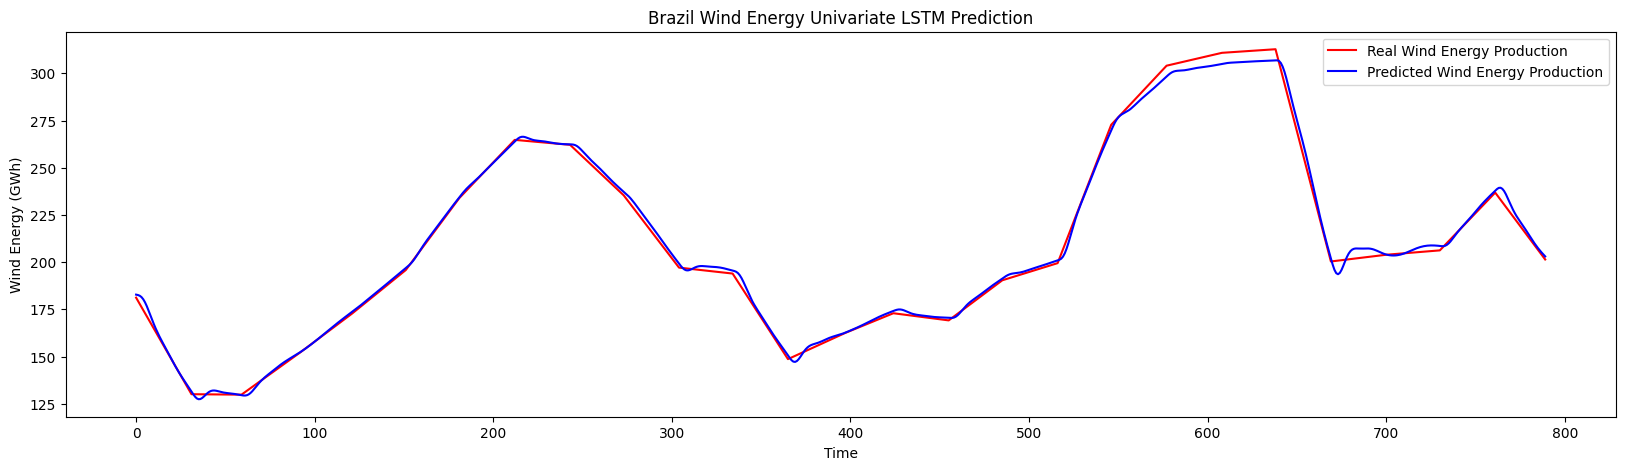

In [125]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Wind Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Wind Energy Production')
plt.title('Brazil Wind Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [126]:
data = wind_production_data['Brazil']

data.shape

(2982, 3)

In [127]:
X = data[['Wind10int', 'Wind100int', 'Value']]
y = data[['Value']]

X.head()

,Wind10int,Wind100int,Value
Date,,,
2015-01-01,1.945945,3.208612,49.778065
2015-01-02,1.946801,3.211605,49.511897
2015-01-03,1.947657,3.214599,49.245729
2015-01-04,1.948513,3.217592,48.979561
2015-01-05,1.949369,3.220586,48.713393


In [128]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [129]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [130]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 3)
(790, 3)

(2193, 1)
(790, 1)


In [131]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previoBrazil time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(1828, 365, 3)


In [132]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [80]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

brz_daily_multi_lstm = Sequential()
brz_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(LSTM(units = 64))
brz_daily_multi_lstm.add(Dropout(0.2))
brz_daily_multi_lstm.add(Dense(1))

In [81]:
brz_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

brz_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 137s 884ms/step - loss: 0.0320
Epoch 2/100
58/58 [==============================] - 52s 899ms/step - loss: 0.0044
Epoch 3/100
58/58 [==============================] - 52s 897ms/step - loss: 0.0040
Epoch 4/100
58/58 [==============================] - 51s 891ms/step - loss: 0.0029
Epoch 5/100
58/58 [==============================] - 54s 922ms/step - loss: 0.0030
Epoch 6/100
58/58 [==============================] - 53s 910ms/step - loss: 0.0027
Epoch 7/100
58/58 [==============================] - 50s 855ms/step - loss: 0.0025
Epoch 8/100
58/58 [==============================] - 52s 900ms/step - loss: 0.0026
Epoch 9/100
58/58 [==============================] - 51s 873ms/step - loss: 0.0024
Epoch 10/100
58/58 [==============================] - 51s 889ms/step - loss: 0.0021
Epoch 11/100
58/58 [==============================] - 51s 879ms/step - loss: 0.0023
Epoch 12/100
58/58 [==============================] - 52s 900ms/step - loss: 0.0021


58/58 [==============================] - 34s 586ms/step - loss: 5.8954e-04
Epoch 97/100
58/58 [==============================] - 30s 517ms/step - loss: 4.9036e-04
Epoch 98/100
58/58 [==============================] - 32s 549ms/step - loss: 4.7202e-04
Epoch 99/100
58/58 [==============================] - 31s 538ms/step - loss: 5.1728e-04
Epoch 100/100
58/58 [==============================] - 32s 560ms/step - loss: 4.5678e-04


In [133]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
multi_lstm_y_pred = brz_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 3)
25/25 [==============================] - 12s 124ms/step


array([[181.38036],
       [181.24031],
       [181.02014],
       [180.64474],
       [180.0491 ],
       [179.16356],
       [177.87395],
       [176.19812],
       [174.19412],
       [171.9324 ],
       [169.48149],
       [166.9351 ],
       [164.3666 ],
       [161.83232],
       [159.37398],
       [157.02391],
       [154.80824],
       [152.74307],
       [150.8321 ],
       [149.07086],
       [147.44968],
       [145.95686],
       [144.57742],
       [143.29343],
       [142.08604],
       [140.936  ],
       [139.82304],
       [138.72568],
       [137.62665],
       [136.51068],
       [135.36171],
       [134.16423],
       [132.90471],
       [131.66296],
       [130.54147],
       [129.63025],
       [128.98828],
       [128.63733],
       [128.56323],
       [128.73058],
       [129.09625],
       [129.61147],
       [130.2325 ],
       [130.90967],
       [131.58163],
       [132.19908],
       [132.72238],
       [133.11519],
       [133.34106],
       [133.3955 ],


In [134]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  10.346149690876791
Mean Squared Error:  320.4418442887956
Root Mean Squared Error:  17.90088948317361


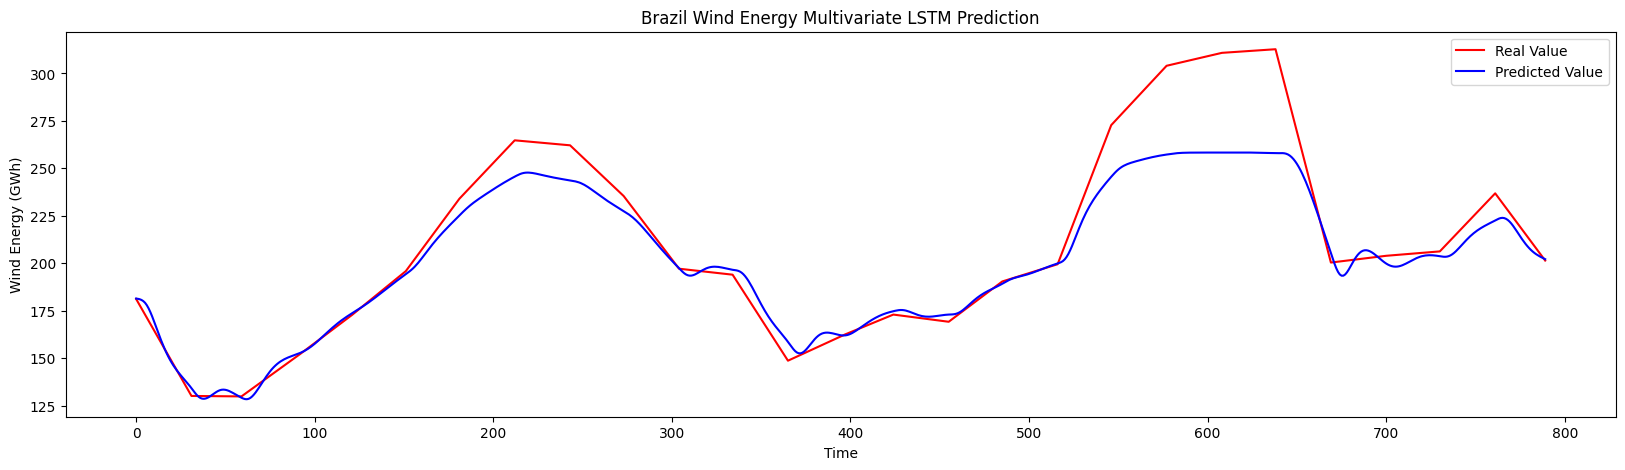

In [135]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Brazil Wind Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

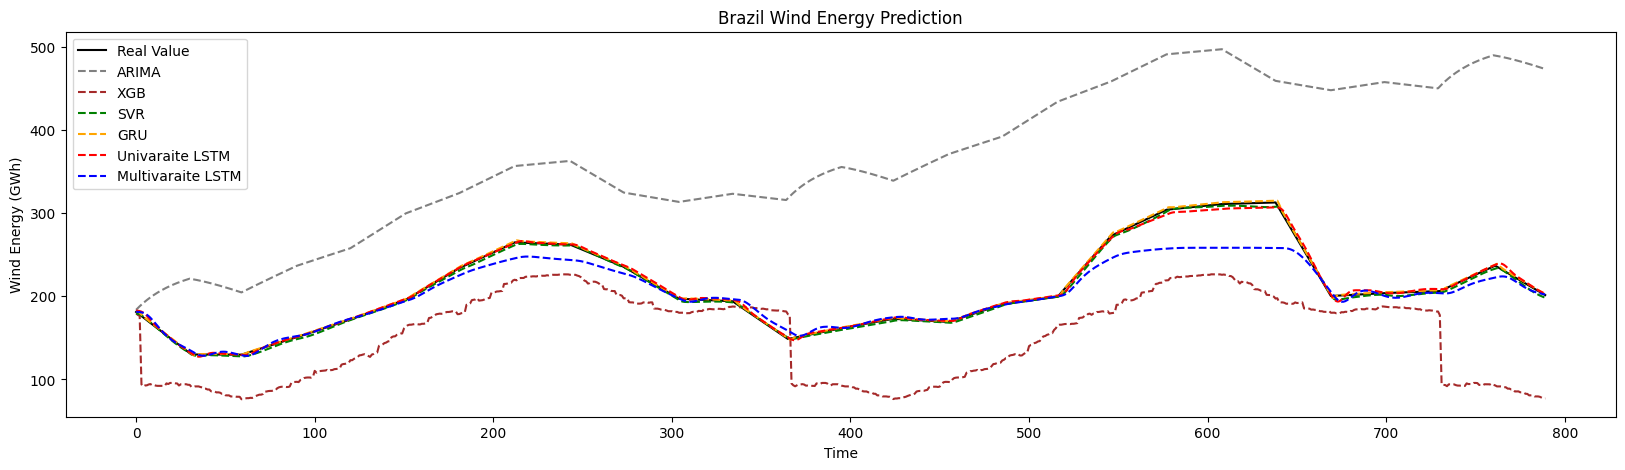

In [137]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(xgb_y_pred, color='brown', linestyle='--', label='XGB')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Brazil Wind Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Wind Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [85]:
brz_daily_gru.save("brz_wind_best_gru.h5")
brz_daily_uni_lstm.save("brz_wind_best_uni_lstm.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
